# Nedir bu Autoencoders?
- **Autoencoders** bir **unsupervised learning** algoritmasıdır, yani train edilecek belirli labeller yok.
#### 1-**Dimension reduction/feature extraction** amacıyla kullanılır. Yani bir inputta en önemli feature'ları extract etmeye çalışır.
- **encoder(compress input)**: inputu ifade edebilecek en iyi featureları ortaya çıkarır. Activation functions and hidden layerlar içerisinde bu işi yapar.(**full connected layer** gibi)
- input => encoder => hiddenlayer-code(bottleneck) => decoder => output
-   x   =>   f()  =>       f(x)=y      =>   g()   =>  g(y)=r
-   **x**(input) ve **r**(output) aynı olmak zorunda. Dolayısıyla:
-   **Mean Square Error(MSE)** = 0 olmalı: x=r, x-r=0, |x-r|^2=0, £(|x-r|^2)=0 olmak zorunda.
-   Eğer x-r!=0 ise => backpropagation yaparak weightler güncellenerek, x ve r'ı birbirine eşitlemeye çalışarak model train edilir ve en doğru sonuç bulunur.
-   input size>hidden size => eşitse bir şey öğrenemez.
#### 2-**Denoising** amacıyla kullanılır, denoising, hatalardan temizlemek demektdir.
- Corrupted bir image inputu ile karşılaştığı zaman, noise'u öğrenir ve bu inputu denoise eder.
#### https://blog.keras.io/building-autoencoders-in-keras.html

In [49]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import json, codecs
from keras.models import load_model
import cv2
import numpy as np

## 1-Read Data
### NOTE
- Autoencoders bir unsupervised learning modeli olduğu için, labellara yani y_train ve y_test değişkenlerine ihtiyacımız yok. 
- Kullanmayacağımız için **y_train** ve **y_test** yerine <bold>_</bold> diye belirtiriz.

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [3]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [4]:
x_train[0][0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=uint8)

## 2-Preprocessing

### A) Convert 32 bit float and Normalize Data

In [5]:
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train[0][0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

### B) Convert to Flatten matrix

In [6]:
print(x_train.shape[0], x_train.shape[1], x_train.shape[2]) # len(x_train) = x_train.shape[0]
print(x_test.shape[0], x_test.shape[1], x_test.shape[2])

60000 28 28
10000 28 28


In [7]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1] * x_train.shape[2])) # 28x28=1x784
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1] * x_test.shape[2]))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


#### NOTE
- Yukarıda vektörel matrise çevirdik ancak matplotta görselleştirmek için orijinal hali gerekli. :(

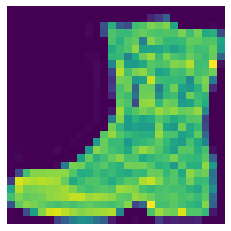

In [8]:
plt.imshow(x_train[150].reshape(28, 28)) 
plt.axis("off")
plt.show()

## 3-Create Autoencoder Model

In [9]:
input_layer = Input(shape = (784, )) # create input(img) layer
input_layer

<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'input_1')>

In [10]:
encoded1 = Dense(32, activation="relu")(input_layer)   # 32 nörondan oluşur. bir önceki layer input_img'yi bağladık.
encoded2 = Dense(16, activation="relu")(encoded1)     # 16 nörondan oluşur. yine bir önceki layer'ı bağladık.

In [11]:
decoded = Dense(32, activation="relu")(encoded2)     # 32 nörondan oluşur. yine bir önceki layer'ı bağladık.
output_layer = Dense(784, activation="sigmoid")(decoded) # 784 nörondan oluşur.yine bir önceki layer'ı bağladık.

In [12]:
autoencoder = Model(input_layer, output_layer)

## 4-Compile and Train Model

In [13]:
autoencoder.compile(optimizer = "rmsprop", loss = "binary_crossentropy", metrics="accuracy")

### NOTE
- Autoencoder bir unsupervised learning modeli olduğu için input ve output aynı olacak. Amaç denoising veya feature extraction yapmak olduğundan input output aynı olmalı. 
- Bu yüzden input=x_train, outpu=x_train olarak yazarız.

In [14]:
hist = autoencoder.fit(x_train,
                       x_train,
                       epochs = 200,
                       batch_size = 256,
                       shuffle = True,
                       validation_data = (x_train, x_train))

Epoch 1/200
235/235 [==============================] - 4s 12ms/step - loss: 0.4075 - accuracy: 0.0083 - val_loss: 0.3531 - val_accuracy: 0.0081
Epoch 2/200
235/235 [==============================] - 3s 11ms/step - loss: 0.3387 - accuracy: 0.0122 - val_loss: 0.3300 - val_accuracy: 0.0163
Epoch 3/200
235/235 [==============================] - 3s 12ms/step - loss: 0.3235 - accuracy: 0.0142 - val_loss: 0.3224 - val_accuracy: 0.0151
Epoch 4/200
235/235 [==============================] - 3s 11ms/step - loss: 0.3178 - accuracy: 0.0131 - val_loss: 0.3143 - val_accuracy: 0.0106
Epoch 5/200
235/235 [==============================] - 3s 11ms/step - loss: 0.3141 - accuracy: 0.0126 - val_loss: 0.3113 - val_accuracy: 0.0150
Epoch 6/200
235/235 [==============================] - 3s 12ms/step - loss: 0.3114 - accuracy: 0.0121 - val_loss: 0.3091 - val_accuracy: 0.0117
Epoch 7/200
235/235 [==============================] - 3s 12ms/step - loss: 0.3093 - accuracy: 0.0122 - val_loss: 0.3073 - val_accuracy:

## 5-Save Model and History

In [16]:
autoencoder.save("demo.h5")
with open("demo.json", "w") as f:
    json.dump(hist.history, f)

## 6-Load Model and History

In [17]:
with codecs.open("demo.json","r", encoding = "utf-8") as f:
    history1 = json.loads(f.read())
model1 = load_model("demo.h5")

In [18]:
history1.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

## 7-Evaluation Model

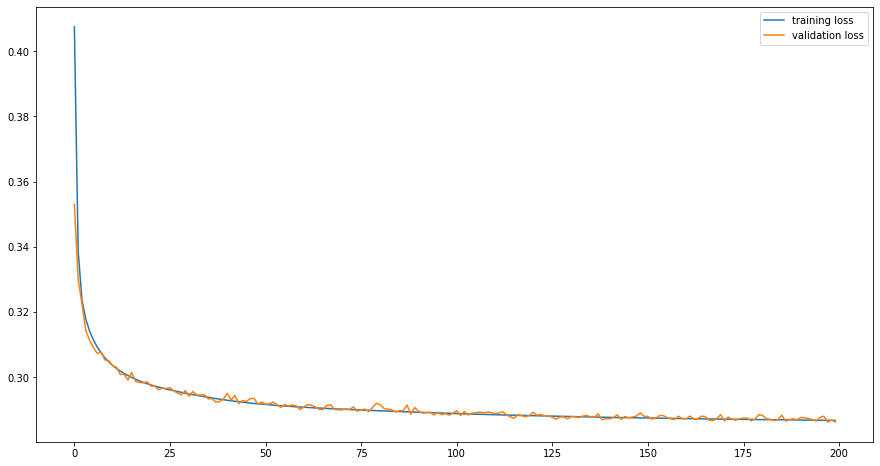

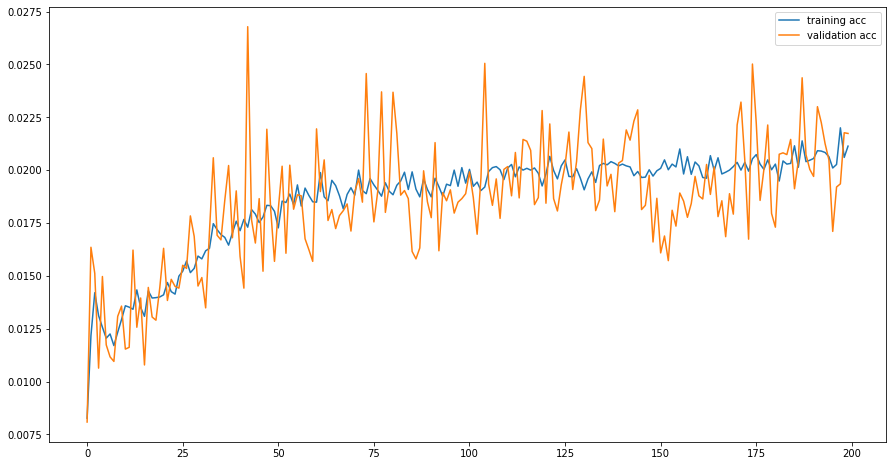

In [19]:
plt.figure(figsize = (15, 8))
plt.plot(history1["loss"], label = "training loss")
plt.plot(history1["val_loss"], label = "validation loss")
plt.legend()
plt.show()
plt.figure(figsize = (15, 8))
plt.plot(history1["accuracy"], label = "training acc")
plt.plot(history1["val_accuracy"], label = "validation acc")
plt.legend()
plt.show()

## 8-Test Data

In [117]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 32)                25120     
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 32)                544       
                                                                 
 dense_3 (Dense)             (None, 784)               25872     
                                                                 
Total params: 52,064
Trainable params: 52,064
Non-trainable params: 0
_________________________________________________________________


In [122]:
encoder2 = Model(input_layer,encoded2)
encoded_img2 = encoder2.predict(x_test)

In [123]:
decoded_imgs = autoencoder.predict(x_test)

In [125]:
%matplotlib qt5

n = 10
fig, axs = plt.subplots(3, 10, constrained_layout = True,figsize=(18,9), dpi=96) # 2x3 plots and fixed figure size. PLEASE DONT CHANGE THE SIZE :)
fig.suptitle('Layerların Karşılaştırması')

for i in range(n):

    # display original
    axs[0,4].set_title("Input Layer")
    axs[0][i].imshow(x_test[i].reshape(28, 28))
    axs[0][i].axis("off")

    # display encoded2
    axs[1,4].set_title("Second Encoded Layer")
    axs[1][i].imshow(encoded_img2[i].reshape(4, 4))
    axs[1][i].axis("off")

    axs[2,4].set_title("Output Layer")
    axs[2][i].imshow(decoded_imgs[i].reshape(28, 28))
    axs[2][i].axis("off")
    
plt.savefig("sample_fig.png") # isteğe bağlı kaydedilebilir.
plt.show()